In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score

## Load the data 🎉😎🧬

In [2]:
notebook_dir = os.getcwd()
features_file = os.path.join(notebook_dir, '../data/toy_expression.tsv')
labels_file = os.path.join(notebook_dir, '../data/toy_labels.tsv')

features_df = pd.read_csv(features_file, sep='\t', index_col=0)
labels_df = pd.read_csv(labels_file, sep='\t', index_col=0)

## Set up for cross validation 👁👄👁

In [3]:
SEED = 33
X = features_df.T.loc[labels_df.index]
y = labels_df["label"].values
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


## Train a Random Forest 🌲🌳📉

In [9]:
# Store results
accuracies = []
shap_values_all = []
explainer = None

for fold, (train_idx, test_idx) in tqdm(enumerate(cv.split(X, y), 1), total=5, desc='Cross-validation'):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train model
    model = RandomForestClassifier(random_state=SEED) # change the model here
    model.fit(X_train, y_train)

    # Predict and evaluate
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

    # Save metrics for fold one
    if fold == 1:
        # SHAP
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        shap_values_all.append(shap_values)

        # AUROC
        probs = model.predict_proba(X_test)[:, 1]
        first_fold_y_true = y_test
        first_fold_y_probs = probs

# Summary of performance
print(f"\nMean Accuracy 🫡: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

Cross-validation:  80%|████████  | 4/5 [00:00<00:00, 14.59it/s]

Fold 1 Accuracy: 0.0000
Fold 2 Accuracy: 0.0000
Fold 3 Accuracy: 0.5000
Fold 4 Accuracy: 1.0000


Cross-validation: 100%|██████████| 5/5 [00:00<00:00, 14.46it/s]

Fold 5 Accuracy: 0.0000

Mean Accuracy 🫡: 0.3000 ± 0.4000


## SHAP evaluation 🧐📈⚖️

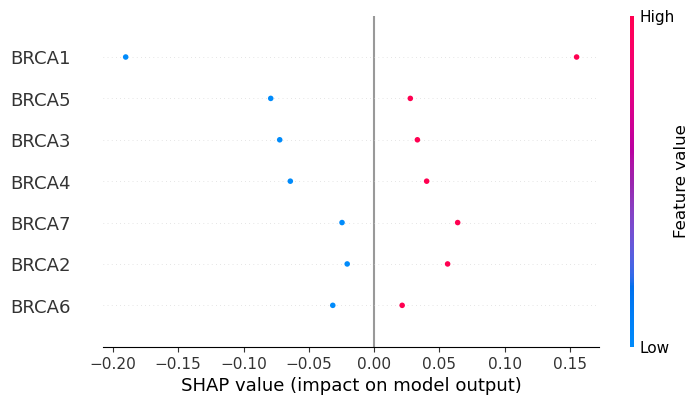

In [10]:
# SHAP summary plot for first fold (class 1 in binary classification)
if shap_values_all:
    shap.plots.beeswarm(shap_values_all[0][:, :, 1])

## AUROC 😱✨⁉️

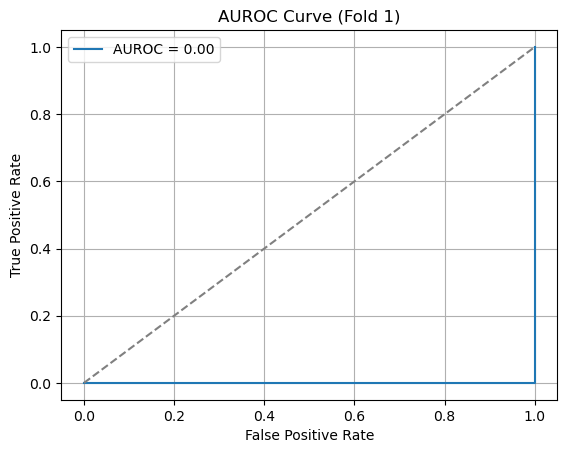

In [11]:
fpr, tpr, _ = roc_curve(first_fold_y_true, first_fold_y_probs)
auc = roc_auc_score(first_fold_y_true, first_fold_y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve (Fold 1)')
plt.legend()
plt.grid(True)
plt.show()